In [1]:
# importing the necessary libraries
import random
import copy
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import output_notebook
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.models.tools import HoverTool
from bokeh.palettes import Inferno256

In [2]:
# creating the passenger class
class Passenger():
    status = 'waiting'  # all passengers are initially waiting
    total_time = 0  # total wait time for passengers
    
    def __init__(self, start_floor, end_floor, pass_id, entry_time=None):
        self.start_floor = start_floor  # passenger's initial floor
        self.end_floor = end_floor  # passenger's destination
        if entry_time != None:
            self.entry_time = entry_time
        else:
            self.entry_time = np.round(sts.truncnorm.rvs(a=(0-2)/0.5, b=(15-2)/0.5, loc=2, scale=0.5, size=1)[0], 2)  # mean entry speed = 2 seconds

        self.pass_id = pass_id  # passenger id number
    
    # to be able to track the status of the passengers ('waiting', 'arrived', 'in elevator')
    # we defined this method
    def update_status(self, status):
        self.status = status
    
    # to be able to call the status of the passengers, we defined this method
    def get_status(self):
        return self.status

In [3]:
# creating the elevator class
class Elevator():  
    total_time = 0  # overall time passed
    total_wait_time = 0  # overall time spent by passenger in the elevator
    prev_floor = None  # keeps track of the previous floor of the elevator
    num_ppl = 0  # number of people in the elevator
    direction = "up"  # direction where the elevator goes
    destinations = []  # creating an empty list, to populate with the destinations of the elevator
    
    def __init__(self, cur_floor, bottom_floor, top_floor, capacity, move_time, door_time):
        self.top_floor = top_floor  # top floor of the apartment
        self.bottom_floor = bottom_floor  # bottom floor of the apartment
        
        self.capacity = capacity  # capacity of the elevator
        self.cur_floor = cur_floor  # position/floor of the elevator
        
        self.move_time = move_time # time to move 1 floor
        self.door_time = door_time # time to open/close door    
        
    # method to update tdestinations list
    def update_destinations(self, destinations):
        self.destinations = destinations
    
    # method to calculate the time that passes between the 2 stops of the elevator
    def time_elapsed(self):
        # firstly we find how many floors the elevator travelled and the door opening/closing time
        self.total_time += abs(self.cur_floor - self.prev_floor) * self.move_time + self.door_time
    
    # method to add the passenger entry time to total time 
    def add_passenger_entry_time(self, passenger_time):
        self.total_time += passenger_time
    
    # updates the floor of the elevator
    def update_floor(self, is_full):
        self.prev_floor = self.cur_floor  # we need the previous floor to calculate time
        self.cur_floor = self.next_floor(is_full)
        self.time_elapsed()
        
# simple example strategy in which the elevator stops at each floor        
class ElevatorSimple(Elevator):
    def __init__(self, cur_floor, bottom_floor, top_floor, capacity, move_time=3, door_time=4):
        super().__init__(cur_floor, bottom_floor, top_floor, capacity, move_time, door_time)
    
    # decides the next floor of the elevator based on the direction
    def next_floor(self, *args):
        
        # elevator keeps going up until it reaches the top floor
        if self.cur_floor == self.top_floor:
            self.direction = "down"
            
        # elevator keeps going down until it reaches the bottom floor
        elif self.cur_floor == self.bottom_floor:
            self.direction = "up"
        
        # updates the number of the current floor based on the direction
        if self.direction == "up":
            next_fl = self.cur_floor + 1
        else:
            next_fl = self.cur_floor - 1
            
        return next_fl
        
# strategy that prioritizes closest requested destinations
class ElevatorDemand(Elevator):
    def __init__(self, cur_floor, bottom_floor, top_floor, capacity, move_time=3, door_time=4):
        super().__init__(cur_floor, bottom_floor, top_floor, capacity, move_time, door_time)
        
        '''
        Format for destinations:
        
        destinations = {
            'waiting': [(2, 4), None, (3, 7)],  # example
            'in elevator': [None, (3, 2), None]
        }
        '''
    # decides the next floor of the elevator based on the closest requested floor   
    def next_floor(self, is_full=False):
        # creates a list of floors where passengers are waiting and floors where passengers want to go
        if not is_full:
            next_destinations = [p[0] for p in self.destinations['waiting'] if p] + [p[1] for p in self.destinations['in elevator'] if p]
        else:
            next_destinations = [p[1] for p in self.destinations['in elevator'] if p]
        next_destinations = list(filter(lambda a: a != self.cur_floor, next_destinations))
        
        # goes to the requested floor that is closest to the elevator's current location
        next_fl = min(next_destinations, key=lambda x: abs(x-self.cur_floor))
        
        return next_fl



In [4]:
# creating the building class
class Building():
    
    #creating the empty lists to be used and setting up parameters
    passengers_reserve = []
    passengers = []
    destinations = []
    elevator = None
    capacity = 0

    bottom_floor = None
    top_floor = None

    MAX_PASS = 50
    MIN_FLOOR = -5
    MAX_FLOOR = 100

    # for plotting
    elev_logs = {}

    def __init__(self, bottom_floor = None, top_floor=None):
        if bottom_floor != None and top_floor != None:
            self.bottom_floor = bottom_floor
            self.top_floor = top_floor
        else:
            self.bottom_floor = random.randint(self.MIN_FLOOR, 1)
            self.top_floor = random.randint(1, self.MAX_FLOOR)
    
    # method to simulate the different elevator algortims
    def simulate(self, elev_algo='simple', capacity=8, show_report=None):
        
        self.capacity = capacity  # capacity of the elevator
        self.clear_logs()  # clears the logs at the start of each simulation
        self.passengers = copy.deepcopy(self.passengers_reserve)  # passengers' list

        # create elevator based on the existing strategies
        if elev_algo == 'simple':
            self.elevator = ElevatorSimple(cur_floor=self.bottom_floor, bottom_floor=self.bottom_floor, top_floor=self.top_floor, capacity=capacity)
        elif elev_algo == 'demand':
            self.elevator = ElevatorDemand(cur_floor=self.bottom_floor, bottom_floor=self.bottom_floor, top_floor=self.top_floor, capacity=capacity)
        else:
            return "Algorithm does not exist. Exiting simulation."

        # call the run function for each scenario
        self.run()

        # report runtime
        if show_report == None:
            self.generate_report()
    
    # this method runs the elevator
    def run(self):
        self.destinations = self.get_destinations()  # gets the list of destinations 
        self.elevator.update_destinations(self.destinations)  # updates destinations for the elevator  
        ids_exit, ids_add = [], []  # ids of exiting and entering passengers

        # keeps the algorithm running until each passenger reaches their destination
        while not self.all_passengers_arrived():
            self.update_logs(ids_exit, ids_add)  # updates the logs based on the exiting and the entering passengers
            self.elevator.update_floor(is_full=(self.elevator.num_ppl==self.capacity))
            ids_exit, ids_add = self.update_elevator_and_passengers()  # checking if any passenger needs to enter/exit
        self.update_logs(ids_exit, ids_add)  # updates the logs as the last step


    # update status of passengers when elevator stops at a floor
    def update_elevator_and_passengers(self):

        # check if not over capacity, update status and number of passengers in elevator
        ids_exit, time_exit = self.exit_passengers()  # exit first to have space
        ids_add, time_add = self.add_passengers()  

        self.elevator.add_passenger_entry_time(time_exit + time_add)

        # updates destination list based on the passenger status 
        for i in ids_exit:
            self.destinations['in elevator'][i] = None
        for i in ids_add:
            self.destinations['in elevator'][i] = self.destinations['waiting'][i]
            self.destinations['waiting'][i] = None

        self.elevator.update_destinations(self.destinations)

        return ids_exit, ids_add
    
    # facilitates the exit of the passengers from the elevator
    def exit_passengers(self):
        passengers_time = 0
        ids_exit = []
        
        # passenger exits when the passenger is in the elevator and the current floor of the elevator
        # is same as the destination floor of the passenger
        for passenger in self.passengers:
            if (passenger.end_floor == self.elevator.cur_floor) & (passenger.status == 'in elevator'):
                passenger.update_status('arrived')  # updates the passenger status to 'arrived'
                self.elevator.num_ppl -= 1  # updates the number of people in the elevator
                ids_exit.append(passenger.pass_id)  # keeps track of the ids of the passengers who existed the elevator
                passengers_time += passenger.entry_time 
                self.elevator.total_wait_time += self.elevator.total_time  # sum of all passenger wait times for a
                                                                           # given simulation (will be used for average
                                                                           # passenger wait time)

                # print("Passenger {0} has exited elevator at floor {1}".format(passenger.pass_id, passenger.end_floor))
        
        self.elevator.add_passenger_entry_time(passengers_time)

        return ids_exit, passengers_time

    # facilitates the enterance of the passengers from the elevator
    def add_passengers(self):
        passengers_time = 0
        ids_add = []

        # passenger enters when the passenger status is 'waiting' and the current floor of the elevator
        # is same as the initial floor of the passnger
        for passenger in self.passengers:
            if (self.elevator.num_ppl < self.elevator.capacity) &\
                    (passenger.start_floor == self.elevator.cur_floor) &\
                    (passenger.status == 'waiting'):
                passenger.update_status('in elevator')  # updates the passenger status to 'in elevator'
                self.elevator.num_ppl += 1  # updates the number of people in the elevator
                ids_add.append(passenger.pass_id)  # keeps track of the ids of the passengers who entered the elevator
                passengers_time += passenger.entry_time

                # print("Passenger {0} has entered elevator at floor {1}".format(passenger.pass_id, passenger.start_floor))

        self.elevator.add_passenger_entry_time(passengers_time)
        
        return ids_add, passengers_time

    # to check if all the passengers arrived to their final destinations 
    def all_passengers_arrived(self):
        for passenger in self.passengers:
            if passenger.get_status() != 'arrived':
                return False
        return True

    # updates the destination list of the elevator based on the passenger status
    def get_destinations(self):
        destinations = {
            'waiting': [],
            'in elevator': []
        }
        for passenger in self.passengers:
            destinations['waiting'].append((passenger.start_floor, passenger.end_floor))
            destinations['in elevator'].append(None)

        return destinations

    # generates passengers. by default, will generate up to 50 passengers (MAX_PASS) in a set.
    def generate_passengers(self, num_pass=None):
        passengers = []
        if num_pass == None:
            num_pass = random.randint(0, self.MAX_PASS)
        
        # assigns an initial and a destination floor to each passenger within the simulation
        for i in range(num_pass):
            x = np.arange(self.bottom_floor, self.top_floor + 1)
            floors = np.random.choice(x, 2, replace = False)
            passengers.append(Passenger(floors[0], floors[1], pass_id=i))

        self.passengers = passengers
        self.passengers_reserve = copy.deepcopy(passengers)
    
    # generates reports of total time and average waiting time for evaluation 
    def generate_report(self):
        print('Total time taken by elevator: {} s'.format(np.round(self.elevator.total_time, 2)))
        # print average time for passengers. total_wait_time is the sum of all passenger wait times.
        print('Average wait time for passengers: {} s'.format(np.round(self.elevator.total_wait_time/len(self.passengers), 2)))

    # clears the logs (this is necessary to use the logs at different iterations of the simulation)
    def clear_logs(self):
        self.elev_logs = {
            'timestamps': [],
            'elev_floor': [],
            'num_ppl_in_elev': [],
            'num_ppl_exit_elev': [],
            'num_ppl_enter_elev': [],
            'ids_exit_elev': [],
            'ids_enter_elev': []
        }

    # updates the logs
    def update_logs(self, ids_exit, ids_add):
        elev_logs = self.elev_logs 
        elev_logs['timestamps'].append(self.elevator.total_time)  # the total time taken by the elevator
        elev_logs['elev_floor'].append(self.elevator.cur_floor)  # current floor of the elevator
        elev_logs['num_ppl_in_elev'].append(self.elevator.num_ppl)  # number of people in the elevator
        elev_logs['num_ppl_exit_elev'].append(len(ids_exit))  # number of the people that exited the elevator
        elev_logs['num_ppl_enter_elev'].append(len(ids_add))  # number of the people that entered the elevator
        elev_logs['ids_exit_elev'].append(ids_exit)  # ids of the people that exited the elevator
        elev_logs['ids_enter_elev'].append(ids_add)  # ids of the people that entered the elevator

    # plots the elevator statistics for evaluation 
    def plot_elevator_stats(self):
        output_notebook() # show plot in jupyter
        color_gradient = np.flip(np.array(Inferno256))[10:180] # color saturation of elevator capacity

        elev_logs_df = pd.DataFrame(self.elev_logs)
        elev_logs_df['color'] = color_gradient[np.abs(np.ceil(elev_logs_df['num_ppl_in_elev'] / self.elevator.capacity * len(color_gradient)).astype(int) - 1)]
        source = ColumnDataSource(elev_logs_df)

        p = figure(plot_width=1600, plot_height=500)

        p.xaxis.axis_label = "Time [s]"
        p.yaxis.axis_label = "Floor"

        p.line(x='timestamps', y='elev_floor', color='grey', source=source)
        p.circle(x='timestamps', y='elev_floor', size=10, color='color', source=source)

        hover = HoverTool()
        hover.tooltips=[
            ('Number of people in elevator', '@num_ppl_in_elev' + ' out of {}'.format(self.elevator.capacity)),
            ('Number of people exiting elevator', '@num_ppl_exit_elev' + ' (id: @ids_exit_elev)'),
            ('Number of people entering elevator', '@num_ppl_enter_elev'+ ' (id: @ids_enter_elev)'),
        ]
        hover.mode = 'vline'
        p.add_tools(hover)

        show(p)

    def __str__(self):
        out = 'Le Petit Passengers:\n\n'
        ids, starts, ends, speeds = [], [], [], []

        # generating passenger ids, passenger entrance duration, start and end floor
        for passenger in self.passengers:
            ids.append(passenger.pass_id)  # passenger ids
            starts.append(passenger.start_floor)  # start floor of a passenger
            ends.append(passenger.end_floor)  # end floor of a passenger
            speeds.append(passenger.entry_time)  # passenger entrance duration
            # out += 'Passenger {} starts at floor {} and wants to arrive at floor {}\n'.format(passenger.pass_id, passenger.start_floor, passenger.end_floor)
        pass_data = pd.DataFrame({'Passenger ID': ids, 'Start Floor': starts, 'Destination Floor': ends, 'Entrance Duration': speeds}).to_string(index=False)

        return out + pass_data

In [5]:
# generating the building object. capacity of the elevator defaults to 8, but can be modified by the user.
le_petit = Building(bottom_floor=-1, top_floor=12)

In [6]:
# generating passengers. number of passengers and number of floors are user-defined.
le_petit.generate_passengers(num_pass=22)
print(le_petit)

Le Petit Passengers:

 Passenger ID  Start Floor  Destination Floor  Entrance Duration
            0            8                 11               1.55
            1           -1                 11               1.61
            2            9                  6               2.03
            3            1                  0               2.25
            4           12                  2               2.38
            5            4                  1               1.73
            6            9                  0               1.67
            7           11                  7               1.88
            8           12                  9               1.97
            9            2                 10               2.40
           10            5                  9               0.96
           11            0                  1               2.28
           12           10                 -1               1.80
           13           11                  2               3.03
   

In [7]:
# simulating the simple elevator 
le_petit.simulate(elev_algo='simple')

# graph to track the state of the elevator throughout the simulation 
le_petit.plot_elevator_stats()

Total time taken by elevator: 526.88 s
Average wait time for passengers: 291.57 s


Loading BokehJS ...

In [8]:
# simulating the on-demand elevator 
le_petit.simulate(elev_algo='demand')

# graph to track the state of the elevator throughout the simulation
le_petit.plot_elevator_stats()

Total time taken by elevator: 446.88 s
Average wait time for passengers: 262.46 s


Loading BokehJS ...

In [9]:
#simulation on multiple sets of passengers.
elevator_time_simple = []
elevator_time_demand = []
passenger_time_simple = []
passenger_time_demand = []

for i in range(1000):
    # generate the building object and generate a passenger set
    new_building = Building(bottom_floor=0, top_floor=random.randint(3,30))
    new_building.generate_passengers(num_pass=random.randint(5,200))

    # for each method, we collect data on all elevator times and average passenger wait times (waiting + in             elevator)

    # Simple algorithm 
    new_building.simulate(elev_algo='simple', show_report=0)
    elevator_time_simple.append(new_building.elevator.total_time)
    passenger_time_simple.append(new_building.elevator.total_wait_time/len(new_building.passengers))

    # On-demand algorithm 
    new_building.simulate(elev_algo='demand', show_report=0)
    elevator_time_demand.append(new_building.elevator.total_time)
    passenger_time_demand.append(new_building.elevator.total_wait_time/len(new_building.passengers))

# average elevator time for all simulations
average_elevator_time_simple = sum(elevator_time_simple) / len(elevator_time_simple)
average_elevator_time_demand = sum(elevator_time_demand) / len(elevator_time_demand)

# average wait time per passenger for all simulations
average_passenger_time_simple = sum(passenger_time_simple) / len(passenger_time_simple)
average_passenger_time_demand = sum(passenger_time_demand) / len(passenger_time_demand)

# printing
print("Average time taken by the simple elevator :", average_elevator_time_simple)
print("Average time taken by the on-demand elevator :", average_elevator_time_demand)

print("Average passenger total time for simple elevator :", average_passenger_time_simple)
print("Average passenger total time for on-demand elevator  :", average_passenger_time_demand)


Average time taken by the simple elevator : 2114.1725199999996
Average time taken by the on-demand elevator : 1737.6725200000014
Average passenger total time for simple elevator : 1006.6409234407075
Average passenger total time for on-demand elevator  : 859.0653599879477


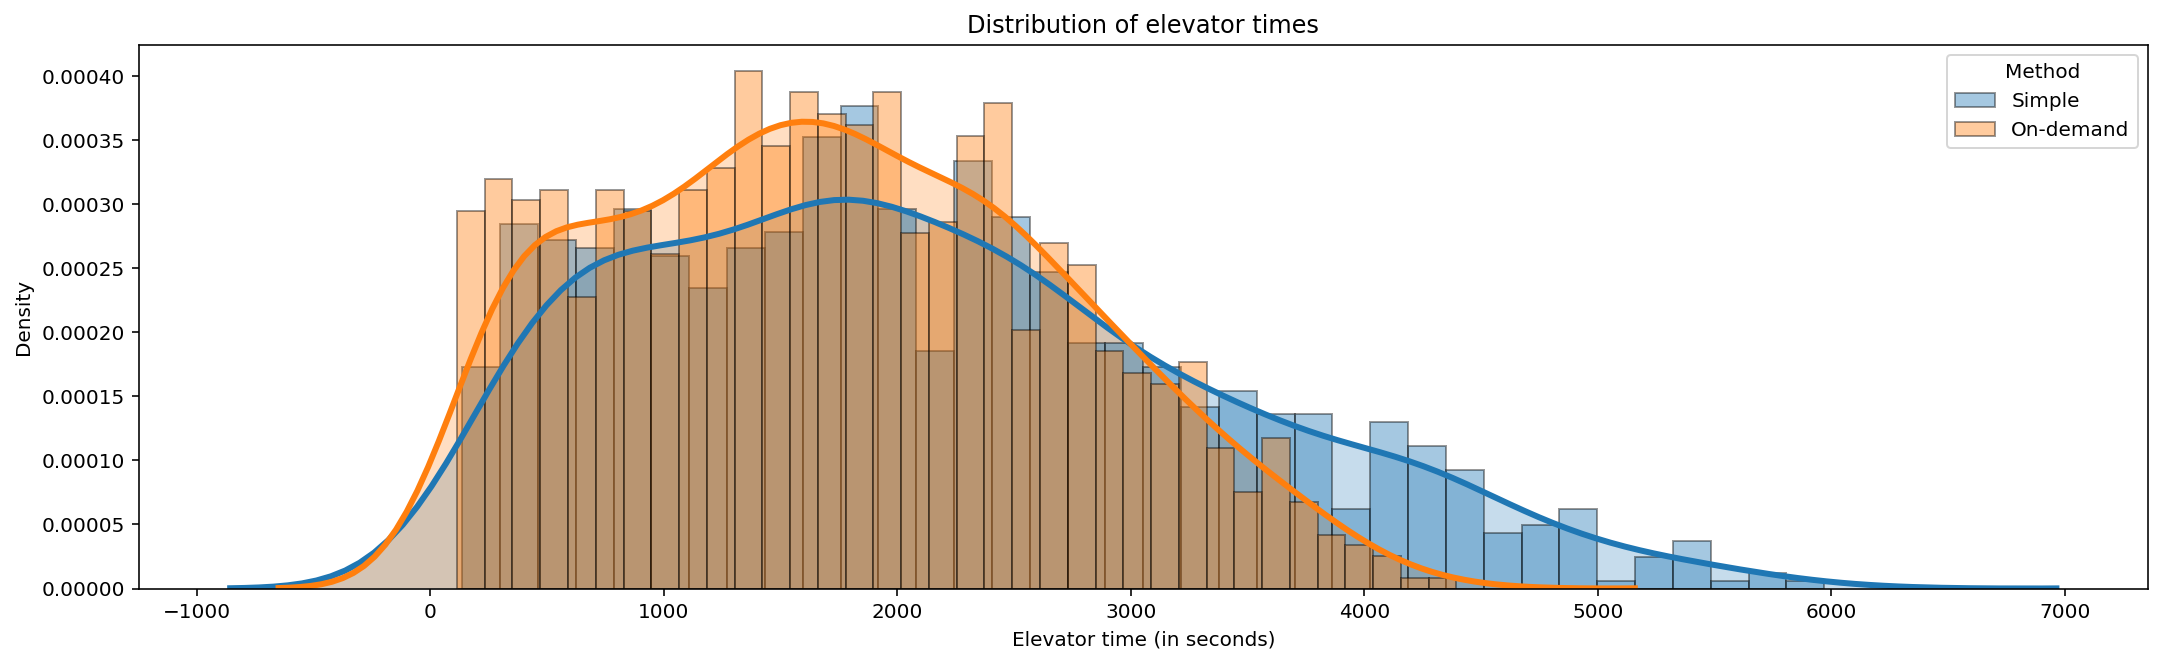

In [10]:
# Comparing algorithms based on time taken by elevator
# Histograms showing the probability corresponding to each elevator time for each algorithm.

plt.figure(figsize=(18, 5))
methods = ['On-demand', 'Simple']

for algo_result in [elevator_time_simple, elevator_time_demand]:
    sns.distplot(algo_result, hist=True, kde=True,
             bins=int(180/5),
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade':True,'linewidth': 3},
             label = methods.pop())


# Plot formatting
plt.legend(prop={'size': 10}, title = 'Method')
plt.title('Distribution of elevator times')
plt.xlabel('Elevator time (in seconds)')
plt.ylabel('Density')

plt.savefig('dist1_CS166_Ass1.svg')
plt.show()

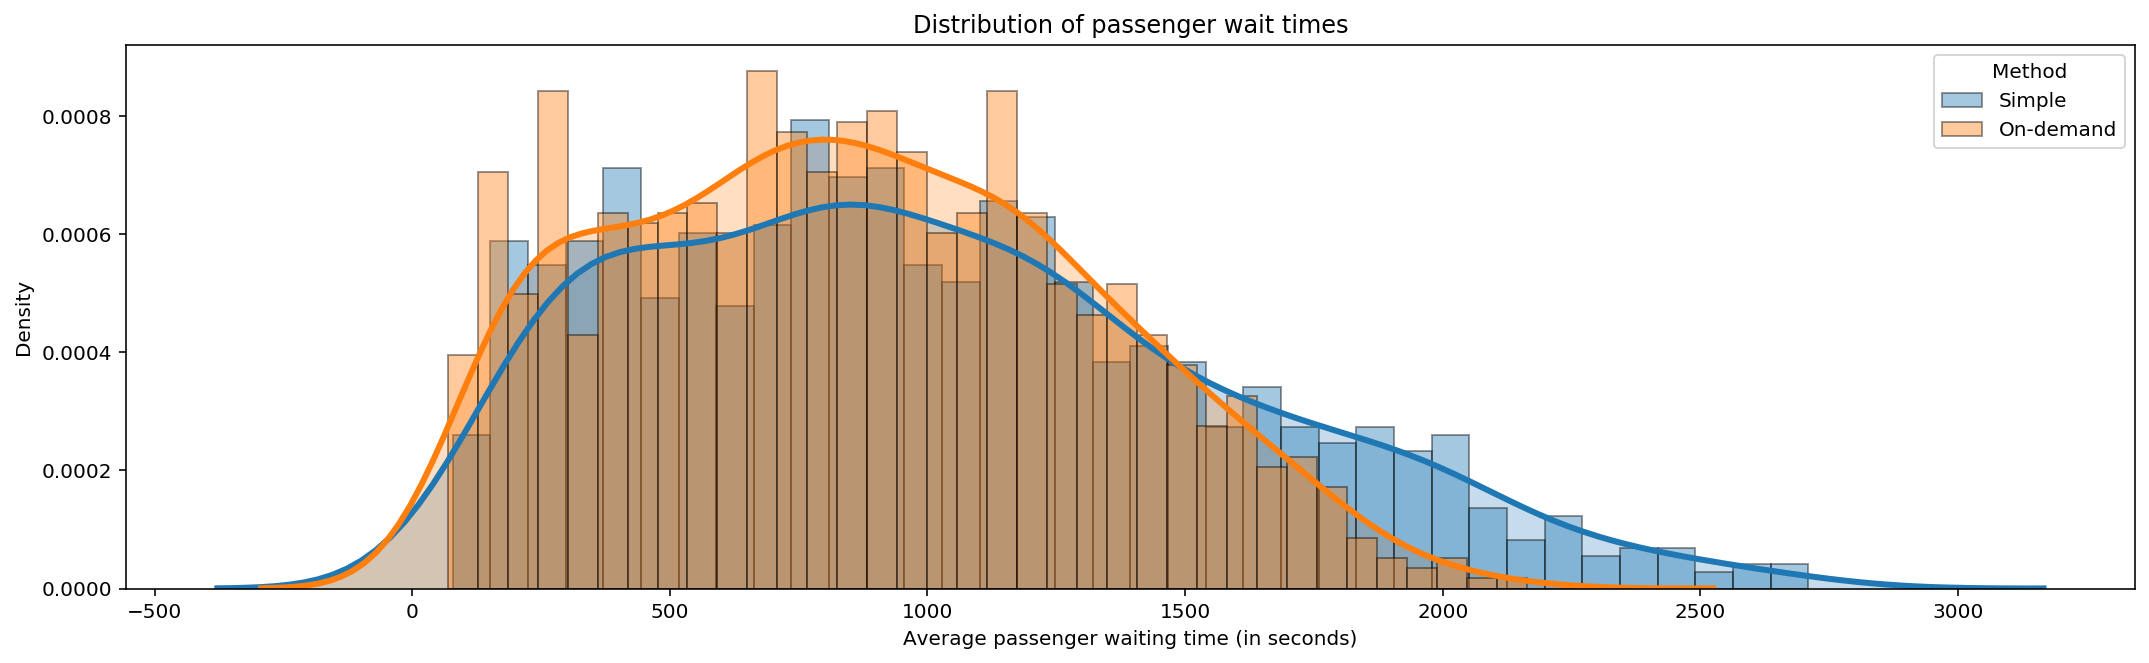

In [11]:
# Comparing algorithms based on average passenger wait time (total)

plt.figure(figsize=(18, 5))
methods = ['On-demand', 'Simple']

for algo_result in [passenger_time_simple, passenger_time_demand]:
    sns.distplot(algo_result, hist=True, kde=True,
             bins=int(180/5),
             hist_kws={'edgecolor':'black'},
             kde_kws={'shade':True,'linewidth': 3},
             label = methods.pop())


# Plot formatting
plt.legend(prop={'size': 10}, title = 'Method')
plt.title('Distribution of passenger wait times')
plt.xlabel('Average passenger waiting time (in seconds)')
plt.ylabel('Density')

plt.show()
